# Group-15 NLP Stock Forecasting
---

*   Hongye Li / hongyeli@usc.edu
*   Quanwei Gu / quanweig@usc.edu 
*   Yucen Xie / yucenxie@usc.edu
*   Yunhao Han / yunhaoha@usc.edu
*   Zhiqi Lu / zhiqilu@usc.edu

## Introduction
This project implements an ensemble deep learning model for stock prediction using S&P 500 Index data and news data collected from CNBC.com, Reuters.com, WSJ.com, and Fortune.com. These datasets were partially obtained from the research of Xinyi et al.(2019) and Yang et al.(2022). 


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/csci544-project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/csci544-project


In [2]:
# install packages and import libs
%pip install keras-self-attention
# %tensorflow_version 2.x
import json
import time
import math
import matplotlib.pyplot as plt
from math import pi,sqrt,exp,pow,log
from abc import ABCMeta, abstractmethod

import numpy as np
from numpy import newaxis
from numpy.linalg import det, inv
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras_self_attention import SeqSelfAttention
from tensorflow import keras
from keras.layers import Dense, Activation, Dropout, LSTM, GRU, Conv1D, MaxPooling1D
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error, precision_score, recall_score, f1_score, classification_report, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# read data
url = './data/source_price_sentiment_oecd.csv'
stock_df= pd.read_csv(url)
stock_df.head()

,date,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,Adj Close,CLI,BCI,CCI
0,2017/12/7,0.296,-0.1366,0.0000,0.0,2636.979980,0.4484,1.3452,1.3407
1,2017/12/8,0.000,0.0000,-0.2423,0.0,2651.500000,0.4484,1.3452,1.3407
2,2017/12/11,0.000,0.0000,0.0000,0.0,2659.989990,0.4484,1.3452,1.3407
3,2017/12/12,0.000,0.0000,0.0000,0.0,2664.110107,0.4484,1.3452,1.3407
4,2017/12/13,0.000,0.0000,0.0000,0.0,2662.850098,0.4484,1.3452,1.3407


# Data Processing



## Dataset

Our dataset contains 121 records/rows, where each one of them represents a trading day ranged from 2017-12-07 to 2018-06-01, and a total of 9 columns. 

* ```date```: date of each trading day (excluding weekends)

*  ```Adj Close``` is the target value we want to predict, which represents the adjusted closing stock price for each trading day.

* Columns with name ending with ```compound``` are sentiment scores generated using stock news gathered from different sources: WSJ, CNBC, Fortune and Reuters. These sentiment scores were computed using **Aware Dictionary and Sentiment Reasoner (VADER)**, which is a lexicon and rule-based model for general sen- timent analysis. VADER will give a compound score for each piece of news data, and the compound score is a metric that calculates the sum of all the lexicon ratings, which has a normalized value ranged in [-1, 1]. -1 means most extreme negative, 0 means neutral, and -1 means most extreme positive.

* ```CLI, BCI, CCI```: Consumer Confidence Index (CCI), the Business Confidence Index (BCI), and the Composite Leading Indicator (CLI) are 3 leading economic indicators, provided by [OECD](https://data.oecd.org/leadind/consumer-confidence-index-cci.htm#indicator-chart), which can generally represent the current heath and performance of the current market.



In [4]:
# read data
url = './data/source_price_sentiment_oecd.csv'
stock_df= pd.read_csv(url)
stock_df.head()

,date,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,Adj Close,CLI,BCI,CCI
0,2017/12/7,0.296,-0.1366,0.0000,0.0,2636.979980,0.4484,1.3452,1.3407
1,2017/12/8,0.000,0.0000,-0.2423,0.0,2651.500000,0.4484,1.3452,1.3407
2,2017/12/11,0.000,0.0000,0.0000,0.0,2659.989990,0.4484,1.3452,1.3407
3,2017/12/12,0.000,0.0000,0.0000,0.0,2664.110107,0.4484,1.3452,1.3407
4,2017/12/13,0.000,0.0000,0.0000,0.0,2662.850098,0.4484,1.3452,1.3407


In [5]:
stock_df.tail()

,date,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,Adj Close,CLI,BCI,CCI
116,2018/5/25,0.030290,0.047433,0.011550,-0.025190,2721.330078,0.7426,1.2187,1.5006
117,2018/5/29,-0.052796,0.070442,-0.025721,-0.035568,2689.860107,0.7426,1.2187,1.5006
118,2018/5/30,-0.017367,0.038119,-0.076965,-0.063177,2724.010010,0.7426,1.2187,1.5006
119,2018/5/31,-0.018636,0.057371,-0.064138,-0.025489,2705.270020,0.7426,1.2187,1.5006
120,2018/6/1,0.000000,-0.061150,0.361200,-0.004489,2734.620117,0.7163,1.3308,1.4417


In [6]:
# use date as index
stock_df.index = stock_df.date
stock_df.drop('date', axis=1, inplace=True)

In [7]:
# nomalize adjust close stock price
adjust_close=stock_df['Adj Close'].values
CLI=stock_df['CLI'].values
BCI=stock_df['BCI'].values
CCI=stock_df['CCI'].values
scaler = MinMaxScaler()
scaled_adjust_close = scaler.fit_transform(adjust_close.reshape(-1,1))
new_stock_df = stock_df.drop(['Adj Close'],axis=1)
new_stock_df['close_price'] = scaled_adjust_close

new_stock_df['CLI'] = scaler.fit_transform(adjust_close.reshape(-1,1))
new_stock_df['BCI'] = scaler.fit_transform(adjust_close.reshape(-1,1))
new_stock_df['CCI'] = scaler.fit_transform(adjust_close.reshape(-1,1))
new_stock_df.head()

,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,CLI,BCI,CCI,close_price
date,,,,,,,,
2017/12/7,0.296,-0.1366,0.0000,0.0,0.191798,0.191798,0.191798,0.191798
2017/12/8,0.000,0.0000,-0.2423,0.0,0.241546,0.241546,0.241546,0.241546
2017/12/11,0.000,0.0000,0.0000,0.0,0.270634,0.270634,0.270634,0.270634
2017/12/12,0.000,0.0000,0.0000,0.0,0.284750,0.284750,0.284750,0.284750
2017/12/13,0.000,0.0000,0.0000,0.0,0.280433,0.280433,0.280433,0.280433


In [8]:
new_stock_df.shape

(121, 8)

## Train-Validation-Test split

Split data into 85% train-validation data and 15% test data. 

In [9]:
# Train-test split. 85% train and 15% test
train_validation_data, test_data= train_test_split(new_stock_df, train_size=0.85, test_size=0.15,shuffle=False)

In [10]:
validation_data =train_validation_data[83:]
train_data=train_validation_data[:83]

print("Train data shape: ", train_data.shape)
print("Validation data shape: ", validation_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (83, 8)
Validation data shape:  (19, 8)
Test data shape:  (19, 8)


## Time Series Data Processing

Since the dataset we are working on uses date as index, and we need to deal with time series forecasting, which means we cannot use future data to make predictions on past data, we are using a sliding window with size=10 so that we can use the past 10 days to predict the next day.

In [11]:
look_back = 10 # sliding window size
forward_days = 1 # prediction size
NUM_NEURONS=50 # number of neurons per layer
EPOCHES=100 
BATCH_SIZE=32
DROUP_OUT=0.2

In [12]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def getTimeSteps(data, look_back, forward_days,jump=1):
    x,y = [],[]
    for i in range(0,len(data) -look_back, jump):
        x.append(data[i:(i+look_back)])
        y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(x), np.array(y)

In [13]:
x_train,y_train = getTimeSteps(train_data.to_numpy(),look_back,forward_days)
x_validation,y_validation = getTimeSteps(validation_data.to_numpy(),look_back,forward_days)
x_test,y_test = getTimeSteps(test_data.to_numpy(),look_back,forward_days)

In [14]:
# extract only the close_price column as Y
y_train = y_train[:,0,-1]
y_validation = y_validation[:,0,-1]
y_test = y_test[:,0,-1]

print("y_train shape: ", y_train.shape)
print("y_validation shape: ", y_validation.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (73,)
y_validation shape:  (9,)
y_test shape:  (9,)


# Level-1 Models

## LSTM model

Built a LSTM model consists of four hidden layers, and each one contains 50 neurons. 0.2 drop-out layers were added between every two hidden layers. During each epoch, we computed the MSE and used Adam as optimizer.



In [15]:
# LSTM model
model1 = Sequential()
# layer 1
model1.add(LSTM(units=NUM_NEURONS, return_sequences = True, input_shape=(x_train.shape[1],x_train.shape[2])))
model1.add(Dropout(DROUP_OUT))
# layer 2
model1.add(LSTM(units=NUM_NEURONS, return_sequences = True))
model1.add(Dropout(DROUP_OUT))
# layer 3
model1.add(LSTM(units=NUM_NEURONS, return_sequences = True))
model1.add(Dropout(DROUP_OUT))
# layer 4
model1.add(LSTM(units=NUM_NEURONS))
model1.add(Dropout(DROUP_OUT))
# output layer
model1.add(Dense(forward_days))
# train
model1.compile(loss='mean_squared_error',optimizer='adam', metrics=['mse'])  
history1 =model1.fit(x_train, y_train, epochs = EPOCHES, batch_size = BATCH_SIZE)
# collect training loss
model1_train_loss = history1.history['loss']

Train on 73 samples
Epoch 1/100
73/73 [==============================] - 1s 16ms/sample - loss: 0.2575 - mean_squared_error: 0.2575
Epoch 2/100
73/73 [==============================] - 0s 997us/sample - loss: 0.1550 - mean_squared_error: 0.1550
Epoch 3/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0808 - mean_squared_error: 0.0808
Epoch 4/100
73/73 [==============================] - 0s 950us/sample - loss: 0.0602 - mean_squared_error: 0.0602
Epoch 5/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0664 - mean_squared_error: 0.0664
Epoch 6/100
73/73 [==============================] - 0s 973us/sample - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 7/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0681 - mean_squared_error: 0.0681
Epoch 8/100
73/73 [==============================] - 0s 978us/sample - loss: 0.0573 - mean_squared_error: 0.0573
Epoch 9/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0562 -

## GRU Model

Built a GRU model with similar structure to the previous LSTM model. Used RMSprop as Optimizer.

In [16]:
# GRU model
model2 = Sequential()
# layer 1
model2.add(GRU(units=NUM_NEURONS, return_sequences = True, input_shape=(x_train.shape[1],x_train.shape[2])))
model2.add(Dropout(DROUP_OUT))
# layer 2
model2.add(GRU(units=NUM_NEURONS, return_sequences = True))
model2.add(Dropout(DROUP_OUT))
# layer 3
model2.add(GRU(units=NUM_NEURONS, return_sequences = True))
model2.add(Dropout(DROUP_OUT))
# layer 4
model2.add(GRU(units=NUM_NEURONS))
model2.add(Dropout(DROUP_OUT))
# output layer
model2.add(Dense(forward_days))
# train
model2.compile(loss='mean_squared_error',optimizer='rmsprop')              
history2 =model2.fit(x_train, y_train, epochs = EPOCHES, batch_size = BATCH_SIZE)
# collect training loss
model2_train_loss = history2.history['loss']

Train on 73 samples
Epoch 1/100
73/73 [==============================] - 2s 32ms/sample - loss: 0.2195
Epoch 2/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0523
Epoch 3/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.0637
Epoch 4/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.0583
Epoch 5/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.0444
Epoch 6/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.0427
Epoch 7/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.0563
Epoch 8/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 9/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0346
Epoch 10/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 11/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.0534
Epoch 12/100
73/73 [==============================] - 0s 2ms/sample - loss:

## Attention

In [17]:
# Attention model (with LSTM)
model3 = Sequential()
# layer 1
model3.add(LSTM(units=NUM_NEURONS, return_sequences = True, input_shape=(x_train.shape[1],x_train.shape[2])))
model3.add(Dropout(DROUP_OUT))
# layer 2
model3.add(SeqSelfAttention(attention_activation='sigmoid',attention_width=3, history_only=True, attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL))
# layer 3
model3.add(LSTM(units=NUM_NEURONS))
model3.add(Dropout(DROUP_OUT))
# output layer
model3.add(Dense(forward_days))
# train 
model3.compile(loss='mean_squared_error', optimizer='adam')
history3 =model3.fit(x_train, y_train, epochs = EPOCHES, batch_size = BATCH_SIZE)
# collect training loss
model3_train_loss = history3.history['loss']

Train on 73 samples
Epoch 1/100
73/73 [==============================] - 2s 26ms/sample - loss: 0.2677
Epoch 2/100
73/73 [==============================] - 0s 597us/sample - loss: 0.1299
Epoch 3/100
73/73 [==============================] - 0s 667us/sample - loss: 0.0512
Epoch 4/100
73/73 [==============================] - 0s 813us/sample - loss: 0.0575
Epoch 5/100
73/73 [==============================] - 0s 771us/sample - loss: 0.0838
Epoch 6/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0551
Epoch 7/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0535
Epoch 8/100
73/73 [==============================] - 0s 850us/sample - loss: 0.0495
Epoch 9/100
73/73 [==============================] - 0s 919us/sample - loss: 0.0517
Epoch 10/100
73/73 [==============================] - 0s 706us/sample - loss: 0.0480
Epoch 11/100
73/73 [==============================] - 0s 703us/sample - loss: 0.0487
Epoch 12/100
73/73 [==============================] - 0s 79

## CNN_LSTM

In [18]:
# build CNN_LSTM model
model4 = Sequential()
# conv layer
model4.add(Conv1D(filters=32, kernel_size=1, activation='tanh', padding='same', input_shape=(10, 8)))
# maxpooling layer
model4.add(MaxPooling1D(pool_size=1, padding='same'))
# LSTM layer
model4.add(LSTM(units=NUM_NEURONS, activation='tanh'))
model4.add(Dropout(DROUP_OUT))
# output layer
model4.add(Dense(forward_days))
# train model
model4.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
history4 = model4.fit(x_train, y_train, epochs=EPOCHES, batch_size=64, verbose=1, shuffle =True)

Train on 73 samples
Epoch 1/100
73/73 [==============================] - 0s 4ms/sample - loss: 0.0754 - mean_squared_error: 0.0754 - mean_absolute_error: 0.2270
Epoch 2/100
73/73 [==============================] - 0s 258us/sample - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1293
Epoch 3/100
73/73 [==============================] - 0s 275us/sample - loss: 0.0461 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1644
Epoch 4/100
73/73 [==============================] - 0s 267us/sample - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1326
Epoch 5/100
73/73 [==============================] - 0s 237us/sample - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1284
Epoch 6/100
73/73 [==============================] - 0s 266us/sample - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1481
Epoch 7/100
73/73 [==============================] - 0s 262us/sample - loss: 0.0381 - mean_squared_error: 0.0381 - mean_abso

In [19]:
# make predictions on Validation data
y_hat_validation_1 = model1.predict(x_validation)
y_hat_validation_2 = model2.predict(x_validation)
y_hat_validation_3 = model3.predict(x_validation)
y_hat_validation_4 = model4.predict(x_validation)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [20]:
# Undo the scaling
y_validation = y_validation.reshape(-1,1)
y_validation_unscaled = scaler.inverse_transform(y_validation)
y_validation.reshape(-1,1)

array([[0.18350648],
       [0.20008866],
       [0.29444584],
       [0.3046215 ],
       [0.22972564],
       [0.25285236],
       [0.18730908],
       [0.16695776],
       [0.28238561]])

In [21]:
y_validation_unscaled

array([[2634.560059],
       [2639.399902],
       [2666.939941],
       [2669.909912],
       [2648.050049],
       [2654.800049],
       [2635.669922],
       [2629.72998 ],
       [2663.419922]])

In [22]:
y_hat_validation_1 = scaler.inverse_transform(y_hat_validation_1)
y_hat_validation_2 = scaler.inverse_transform(y_hat_validation_2)
y_hat_validation_3 = scaler.inverse_transform(y_hat_validation_3)
y_hat_validation_4 = scaler.inverse_transform(y_hat_validation_4)

In [23]:
# make predictions on test data use level-1 models repectively
y_hat_test_1 = model1.predict(x_test) # test LSTM
y_hat_test_2 = model2.predict(x_test) # test GRU
y_hat_test_3 = model3.predict(x_test) # test Attention
y_hat_test_4 = model4.predict(x_test) # test CNN

y_hat_test_1 = scaler.inverse_transform(y_hat_test_1)
y_hat_test_2 = scaler.inverse_transform(y_hat_test_2)
y_hat_test_3 = scaler.inverse_transform(y_hat_test_3)
y_hat_test_4 = scaler.inverse_transform(y_hat_test_4)

y_test = y_test.reshape(-1,1)
y_test = scaler.inverse_transform(y_test)

In [24]:
y_test

array([[2733.01001 ],
       [2724.439941],
       [2733.290039],
       [2727.76001 ],
       [2721.330078],
       [2689.860107],
       [2724.01001 ],
       [2705.27002 ],
       [2734.620117]])

In [25]:
LSTM_mse =  mean_squared_error(y_hat_test_1, y_test)
GRU_mse = mean_squared_error(y_hat_test_2, y_test)
Attention_mse = mean_squared_error(y_hat_test_3, y_test)
CNN_mse = mean_squared_error(y_hat_test_4, y_test)
print("LSTM model test MSE: ", LSTM_mse)
print("GRU model test MSE: ", GRU_mse)
print("Attention test MSE: ", Attention_mse)
print("CNN test MSE: ", CNN_mse)

LSTM model test MSE:  263.3980446345233
GRU model test MSE:  249.77832894952255
Attention test MSE:  280.6857450468671
CNN test MSE:  321.0498506155566


# Level-2 Blending Ensemble Model

After we obtain the preditions of validation data for all 3 level-1 models, we combine them together into a new training dataset. This new dataset will be passed to the second level to train the meta-learner(level-2 model).

In [26]:
ensemble_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(18, activation='relu'),
    keras.layers.Dense(9, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1)
])

In [27]:
ensemble_model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])

In [28]:
scaler = MinMaxScaler()
scaled_y_hat_validation_1 = scaler.fit_transform(y_hat_validation_1)
scaled_y_hat_validation_2 = scaler.fit_transform(y_hat_validation_2)
scaled_y_hat_validation_3 = scaler.fit_transform(y_hat_validation_3)
scaled_y_hat_validation_4 = scaler.fit_transform(y_hat_validation_4)
scaled_y_validation = scaler.fit_transform(y_validation_unscaled)

# combine three validation predictions as new train dataset for the ensemble model
train_data_level2 = np.concatenate((scaled_y_hat_validation_1, scaled_y_hat_validation_2, scaled_y_hat_validation_3, scaled_y_hat_validation_4), axis=-1)

In [29]:
ensemble_model.fit(train_data_level2, scaled_y_validation, epochs=100, batch_size=2)

Train on 9 samples
Epoch 1/100
9/9 [==============================] - 0s 17ms/sample - loss: 0.3002 - mean_absolute_error: 0.4203
Epoch 2/100
9/9 [==============================] - 0s 2ms/sample - loss: 0.2554 - mean_absolute_error: 0.3808
Epoch 3/100
9/9 [==============================] - 0s 1ms/sample - loss: 0.2292 - mean_absolute_error: 0.3716
Epoch 4/100
9/9 [==============================] - 0s 1ms/sample - loss: 0.2176 - mean_absolute_error: 0.3671
Epoch 5/100
9/9 [==============================] - 0s 1ms/sample - loss: 0.2052 - mean_absolute_error: 0.3706
Epoch 6/100
9/9 [==============================] - 0s 1ms/sample - loss: 0.1967 - mean_absolute_error: 0.3758
Epoch 7/100
9/9 [==============================] - 0s 1ms/sample - loss: 0.1894 - mean_absolute_error: 0.3628
Epoch 8/100
9/9 [==============================] - 0s 1ms/sample - loss: 0.1803 - mean_absolute_error: 0.3648
Epoch 9/100
9/9 [==============================] - 0s 1ms/sample - loss: 0.1765 - mean_absolute_erro

Next, we combine the test predictions generated by level-1 sub-models into a new test dataset. The meta-learner will make final predictions on this new test dataset.

In [30]:
# combine test predictions generated by level1 sub-models
scaled_y_hat_test_1 = scaler.fit_transform(y_hat_test_1)
scaled_y_hat_test_2 = scaler.fit_transform(y_hat_test_2)
scaled_y_hat_test_3 = scaler.fit_transform(y_hat_test_3)
scaled_y_hat_test_4 = scaler.fit_transform(y_hat_test_4)

test_data_level2 = np.concatenate((scaled_y_hat_test_1, scaled_y_hat_test_2, scaled_y_hat_test_3, scaled_y_hat_test_4), axis=-1)

In [31]:
y_hat_ensemble = ensemble_model.predict(test_data_level2)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [32]:
# undo the scaling to get the valid stock price
ensemble_predicted_stock_price = scaler.inverse_transform(y_hat_ensemble)
ensemble_predicted_stock_price

array([[2713.783 ],
       [2709.3564],
       [2709.6243],
       [2709.9773],
       [2709.3928],
       [2709.0361],
       [2723.915 ],
       [2723.4897],
       [2720.0876]], dtype=float32)

In [33]:
ensemble_mse = mean_squared_error(ensemble_predicted_stock_price, y_test)
print("MSE of the Blending Ensemble: ", ensemble_mse)

MSE of the Blending Ensemble:  280.7625781757515


# Result Analysis

In [34]:
def format_score(y_tf, Y_tf, y, Y):
  report = classification_report(y_tf, Y_tf, output_dict=True)
  label = 'weighted avg'
  mpa = round(float(1 - sum(abs(Y-y) / Y) / len(y)), 6)
  mda = accuracy_score(y_tf, Y_tf)
  return [mpa, report[label]['precision'], report[label]['recall'], report[label]['f1-score'], mda]

m_trends = np.zeros((5, len(y_hat_test_1) - 1))
actual_trends = np.zeros(len(y_hat_test_1) - 1)
for i in range(1, len(y_hat_test_1)):
  m_trends[0][i - 1] = y_hat_test_1[i] > y_hat_test_1[i - 1]
  m_trends[1][i - 1] = y_hat_test_2[i] > y_hat_test_2[i - 1]
  m_trends[2][i - 1] = y_hat_test_3[i] > y_hat_test_3[i - 1]
  m_trends[3][i - 1] = y_hat_test_4[i] > y_hat_test_4[i - 1]
  m_trends[4][i - 1] = ensemble_predicted_stock_price[i] > ensemble_predicted_stock_price[i - 1]
  actual_trends[i - 1] = y_test[i] > y_test[i - 1]

LSTM_scores = format_score(m_trends[0], actual_trends, y_hat_test_1, y_test)
GRU_scores = format_score(m_trends[1], actual_trends, y_hat_test_2, y_test)
Attention_scores = format_score(m_trends[2], actual_trends, y_hat_test_3, y_test)
CNN_scores = format_score(m_trends[3], actual_trends, y_hat_test_4, y_test)
ensemble_scores = format_score(m_trends[4], actual_trends, ensemble_predicted_stock_price, y_test)

In [35]:
# Table
# MSE, MPA, Precision, Recall, F1-score, MDA
data = [
    [LSTM_mse, GRU_mse, Attention_mse, CNN_mse, ensemble_mse],
    [LSTM_scores[0], GRU_scores[0], Attention_scores[0], CNN_scores[0], ensemble_scores[0]],
    [LSTM_scores[1], GRU_scores[1], Attention_scores[1], CNN_scores[1], ensemble_scores[1]],
    [LSTM_scores[2], GRU_scores[2], Attention_scores[2], CNN_scores[2], ensemble_scores[2]],
    [LSTM_scores[3], GRU_scores[3], Attention_scores[3], CNN_scores[3], ensemble_scores[3]],
    [LSTM_scores[4], GRU_scores[4], Attention_scores[4], CNN_scores[4], ensemble_scores[4]],
    
]

df_metrics = pd.DataFrame(data=data, 
                          index=['MSE', 'MPA', 'Precision', 'Recall', 'F1-score', 'MDA'], 
                          columns=["LSTM", "GRU", "Attention", "CNN_LSTM", "Blending Ensemble"])
print(df_metrics)

                 LSTM         GRU   Attention    CNN_LSTM  Blending Ensemble
MSE        263.398045  249.778329  280.685745  321.049851         280.762578
MPA          0.995776    0.995669    0.995548    0.994861           0.994295
Precision    0.450000    0.500000    0.450000    0.450000           0.750000
Recall       0.375000    0.500000    0.375000    0.375000           0.750000
F1-score     0.409091    0.500000    0.409091    0.409091           0.750000
MDA          0.375000    0.500000    0.375000    0.375000           0.750000


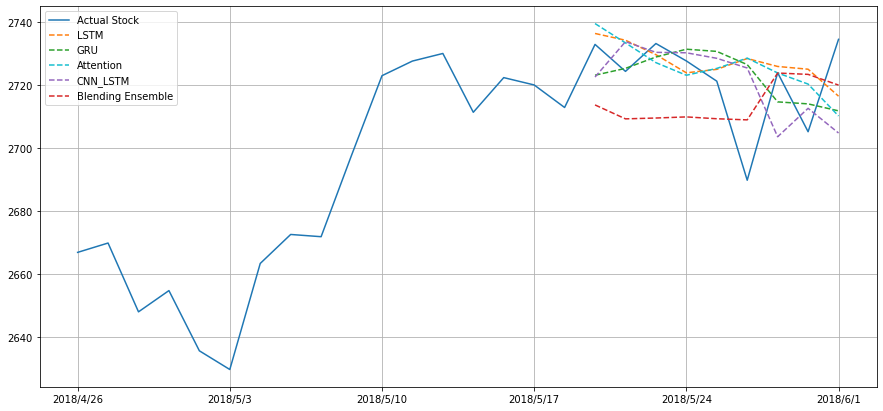

In [36]:
# Charts
fig = plt.figure(figsize = (15, 7))

starting_time_idx = 95
models = ["LSTM", "GRU", "Attention", "CNN_LSTM", "Blending Ensemble"]
colors = ['tab:orange', 'tab:green', 'tab:cyan', 'tab:purple', 'tab:red']
results = [y_hat_test_1, y_hat_test_2, y_hat_test_3, y_hat_test_4, ensemble_predicted_stock_price]

# Actual Stock
plt.plot(stock_df.index[starting_time_idx:], stock_df['Adj Close'][starting_time_idx:], label = 'Actual Stock', c = 'tab:blue')

# Prediction
for i, r in enumerate(results):
    plt.plot(test_data.index[-9:], r, linestyle='dashed', label = '%s' % (models[i]), c = colors[i])

plt.xticks(stock_df.index[starting_time_idx::5], stock_df.index[starting_time_idx::5])
plt.legend()
plt.grid()
plt.show()

# References



1.   Xinyi L., Yinchuan L., Hongyang Y., Liuqing Y., Xi- aoyang L. 2019. DP-LSTM: Differential Privacy- inspired LSTM for Stock Prediction Using Financial News. ArXiv, abs/1912.10806
2.   Yang L., Yi P. 2022. A novel ensemble deep learning model for stock prediction based on stock prices and news. International Journal of Data Science and Analytics, 13(2), 139-149.
